# Imports


In [1]:
import essentia
import math
import essentia.standard as es
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
import numpy as np
from scipy.fft import fft
import functions as f

# Loading Samples


In [2]:
tri = essentia.standard.MonoLoader(filename="new_samples/Tri_440Hz_Cut_1.wav")
tri1 = essentia.standard.MonoLoader(filename="new_samples/Tri+_440Hz_Cut_1.wav")
trisaw = essentia.standard.MonoLoader(filename="new_samples/TriSaw_440Hz_Cut_1.wav")
trisaw1 = essentia.standard.MonoLoader(filename="new_samples/TriSaw+_440Hz_Cut_1.wav")
saw = essentia.standard.MonoLoader(filename="new_samples/Saw_440Hz_Cut_1.wav")

tri_audio = tri().copy()
tri1_audio = tri1().copy()
trisaw_audio = trisaw().copy()
trisaw1_audio = trisaw1().copy()
saw_audio = saw().copy()

sample_dict = {
    "tri": tri_audio,
    "tri+": tri1_audio,
    "trisaw": trisaw_audio,
    "trisaw+": trisaw1_audio,
    "saw": saw_audio,
}

# Plot of the samples


## Cheking if samples have same length


In [3]:
f.checkNumOfSamples(*sample_dict.items())

samples have the same length


True

## Plotting the audios


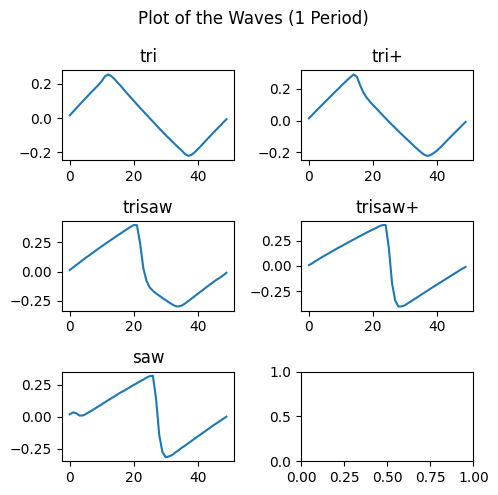

In [32]:
f.plotSamples(**sample_dict)

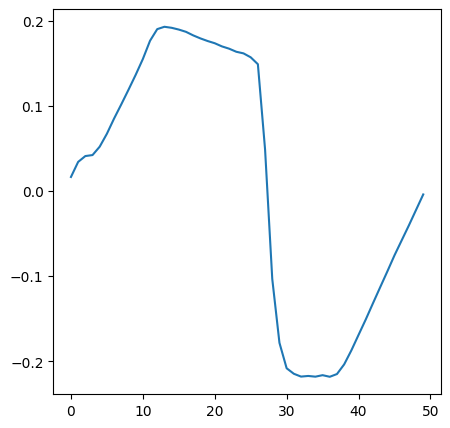

In [33]:
trisaw_sum = (tri_audio + saw_audio) * 0.5
plt.plot(trisaw_sum)
plt.show()

## Linear Regression


### Multiple


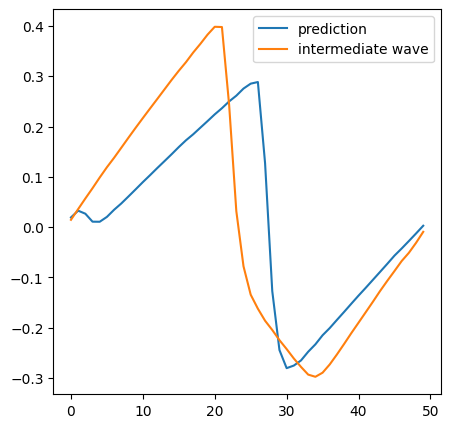

In [34]:
x = pd.DataFrame(saw_audio, tri_audio)
y = pd.DataFrame(trisaw_audio)
mlr = LinearRegression()
mlr.fit(x, y)

y_pred_mlr = mlr.predict(x)

plt.rcParams["figure.figsize"] = (5, 5)
plt.plot(y_pred_mlr, label="prediction")
plt.plot(trisaw_audio, label="intermediate wave")
plt.legend()
plt.show()

# Tecnicas diferentes


## Linear Combination


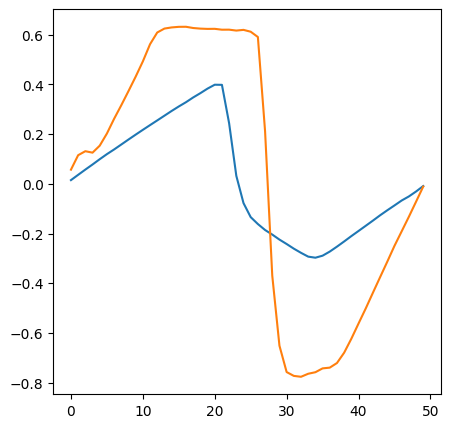

0.12725002


In [35]:
corr_tri = np.correlate(trisaw_audio, tri_audio, mode="same")
corr_saw = np.correlate(trisaw_audio, saw_audio, mode="same")

coef_tri = np.max(corr_tri)
coef_saw = np.max(corr_saw)
aprox = coef_tri * tri_audio + coef_saw * saw_audio

plt.plot(trisaw_audio, label="intermedia")
plt.plot(aprox, label="aprox")
plt.show()

error = np.mean((trisaw_audio - aprox) ** 2)
print(error)

## Fourier Transformed


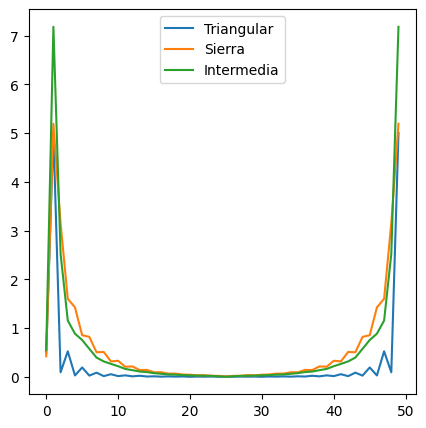

In [36]:
fft_tri = fft(tri_audio)
fft_saw = fft(saw_audio)
fft_trisaw = fft(trisaw_audio)

plt.plot(np.abs(fft_tri), label="Triangular")
plt.plot(np.abs(fft_saw), label="Sierra")
plt.plot(np.abs(fft_trisaw), label="Intermedia")
plt.legend()
plt.show()

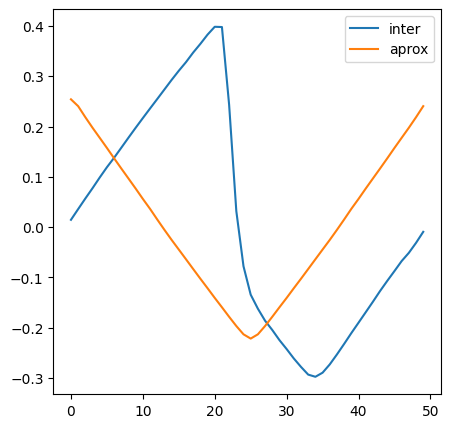

In [37]:
fft_common = np.minimum(np.abs(fft_tri), np.abs(fft_saw))
trisaw_aprox = np.real(np.fft.ifft(fft_common))

plt.plot(trisaw_audio, label="inter")
plt.plot(trisaw_aprox, label="aprox")
plt.legend()
plt.show()

## Polynomial Regression


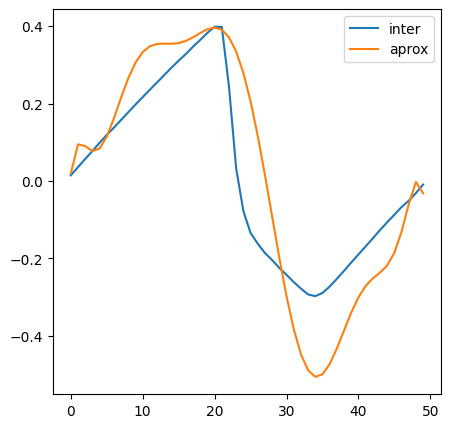

In [38]:
deg = 10
x = np.arange(len(tri_audio))
tri_pol = np.polyfit(x, tri_audio, deg)
saw_pol = np.polyfit(x, saw_audio, deg)

aprox = np.polyval(tri_pol, np.arange(len(trisaw_audio))) + np.polyval(
    saw_pol, np.arange(len(trisaw_audio))
)

plt.plot(trisaw_audio, label="inter")
plt.plot(aprox, label="aprox")
plt.legend()
plt.show()

## PCA


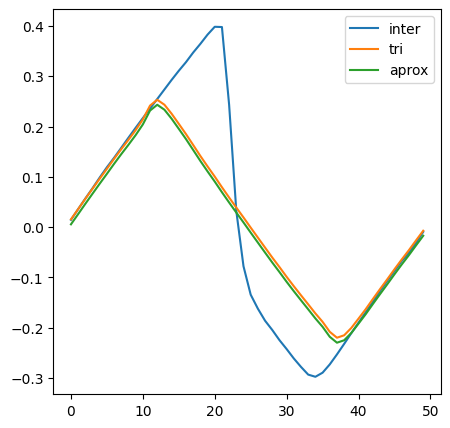

In [39]:
from sklearn.decomposition import PCA

data = np.vstack((tri_audio, saw_audio)).T

pca = PCA(n_components=2)
pca.fit(data)

data_transformed = pca.transform(data)

aprox = np.dot(data_transformed, pca.components_).T[0]

plt.plot(trisaw_audio, label="inter")
plt.plot(tri_audio, label="tri")
plt.plot(aprox, label="aprox")
plt.legend()
plt.show()

## suma logaritmica


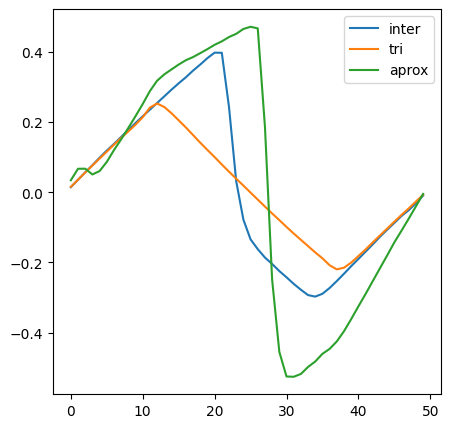

In [40]:
X = 100
w_tri = -(1 - np.log10(X + 1)) / 2
w_saw = -(1 - np.log10(10001 - X)) / 2

aprox = w_tri * tri_audio + w_saw * saw_audio

plt.plot(trisaw_audio, label="inter")
plt.plot(tri_audio, label="tri")
plt.plot(aprox, label="aprox")
plt.legend()
plt.show()

## Linear Interpolation


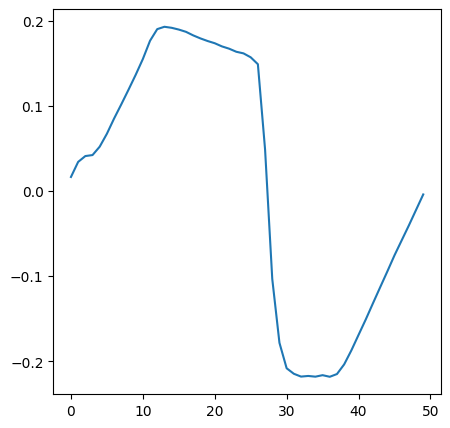

In [41]:
import numpy as np


def waveform(pot):
    # interpolar entre las formas de onda en función del valor del potenciómetro
    wave = pot * tri_audio + (1 - pot) * saw_audio

    return wave


inter_05 = waveform(0.5)
plt.plot(inter_05)
plt.show()

## Interpolacion con ajuste de amplitud


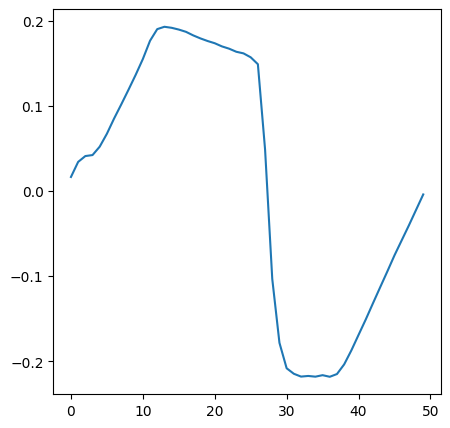

In [42]:
def mix_waveforms(tri_samples, saw_samples, pot_position):
    # Ajusta las amplitudes de las formas de onda según la posición del potenciometro
    tri_factor = 1 - pot_position
    saw_factor = pot_position

    # Interpola los samples de cada forma de onda a la misma longitud
    n_samples = min(len(tri_samples), len(saw_samples))
    x = np.linspace(0, 1, n_samples)
    tri_interp = np.interp(x, np.linspace(0, 1, len(tri_samples)), tri_samples)
    saw_interp = np.interp(x, np.linspace(0, 1, len(saw_samples)), saw_samples)

    # Combina las formas de onda ajustadas según la posición del potenciometro
    mixed_waveform = tri_factor * tri_interp + saw_factor * saw_interp

    return mixed_waveform


aprox = mix_waveforms(tri_audio, saw_audio, 0.5)
plt.plot(aprox)
plt.show()

## interpolacion cubica con splines


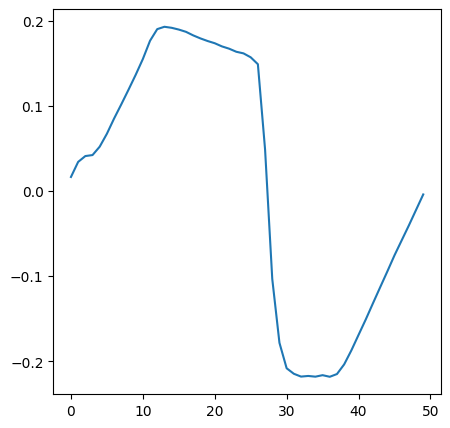

In [43]:
import numpy as np
from scipy.interpolate import CubicSpline


def mix_waveforms(tri_samples, saw_samples, pot_position):
    # Ajusta las amplitudes de las formas de onda según la posición del potenciometro
    tri_factor = 1 - pot_position
    saw_factor = pot_position

    # Interpola los samples de cada forma de onda a la misma longitud
    n_samples = min(len(tri_samples), len(saw_samples))
    x_tri = np.linspace(0, 1, len(tri_samples))
    x_saw = np.linspace(0, 1, len(saw_samples))
    x = np.linspace(0, 1, n_samples)
    tri_interp = CubicSpline(x_tri, tri_samples)(x)
    saw_interp = CubicSpline(x_saw, saw_samples)(x)

    # Combina las formas de onda ajustadas según la posición del potenciometro
    mixed_waveform = tri_factor * tri_interp + saw_factor * saw_interp

    return mixed_waveform


aprox = mix_waveforms(tri_audio, saw_audio, 0.5)
plt.plot(aprox)
plt.show()